<h1 style="font-family:verdana;"> <center>Brain Tumor Detection using Tensorflow CNN</center> </h1>

>**Introduction:** Welcome to my Tensorflow CNN-based Brain Tumor Detection Notebook. I'll investigate both augmented and unaugmented models, providing insights into effective tumor detection. I hope to share informative analysis and insights on everything from data preprocessing to CNN implementation. Join me in gaining valuable insights into medical image analysis.

You can refer to my notebook titled [Brain Tumor Detection EfficientNet|ResNet|Xception](https://www.kaggle.com/code/anitarostami/brain-tumor-detection-efficientnet-resnet-xception) to explore my work on transfer learning techniques.

# Importing Libraries

In [1]:
!pip install mplcyberpunk

In [2]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import mplcyberpunk
plt.style.use("cyberpunk")
import seaborn as sns
import time
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import io
from PIL import Image
from warnings import filterwarnings

2024-05-12 20:36:48.633561: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 20:36:48.633657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 20:36:48.776650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Loading

In [3]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 256
for i in labels:
    folderPath = os.path.join('../input/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 84.89it/s]


# Visualizatioin

**Glioma Tumor:** 
>Originating in the brain or spine's glial cells, gliomas represent 30% of all brain and central nervous system tumors. They are mostly malignant, with symptoms that vary depending on location, frequently resulting in seizures, cognitive impairments, or motor deficits.

**Meningioma Tumor:**
>Meningiomas, arising from the meninges enveloping the brain and spinal cord, are slow-growing tumors. While they typically are asymptomatic, they can cause seizures, cognitive decline, vision disturbances, or motor deficits depending on their location.

**Pituitary Tumor:**
>Pituitary adenomas, mostly benign, occur in the pituitary gland, accounting for 10-25% of intracranial neoplasms. They may cause hormonal imbalances, resulting in a variety of symptoms including headaches, vision changes, or hormonal dysfunctions.


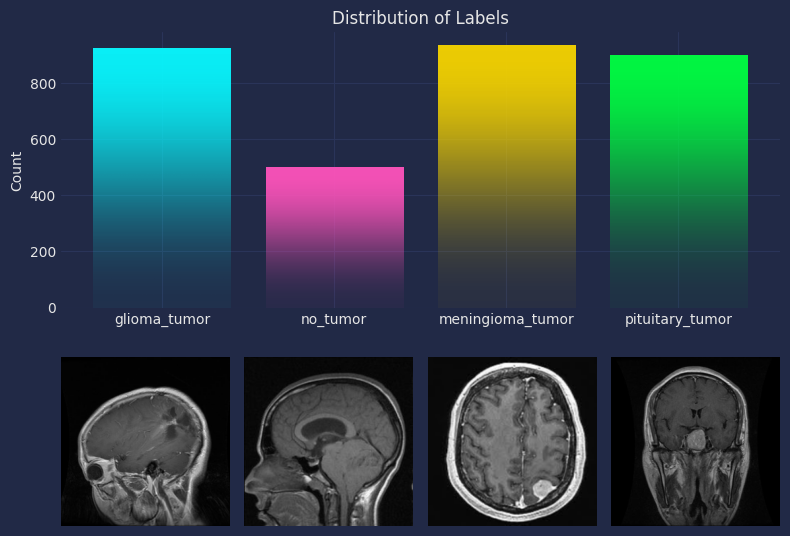

In [4]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

# Data augmentation

📌 **Data augmentation** is an important technique in deep learning for increasing and diversifying existing datasets. Instead of collecting new data, it involves transforming existing data to generate variations. This approach addresses the need for large and diverse datasets, which are required to train robust deep learning models. By augmenting the data, we can effectively increase dataset sizes and diversity, thereby improving the model's ability to generalize to different scenarios.

<p>&nbsp;</p>

*Source:[geeksforgeeks](https://www.geeksforgeeks.org/python-data-augmentation/)*

Overly extreme augmentation parameters can distort images, limiting the model's ability to generalize. For example, excessive rotation or zooming can obscure important image features, resulting in misclassifications.

In [5]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False, 
    fill_mode='nearest')

datagen.fit(X_train)

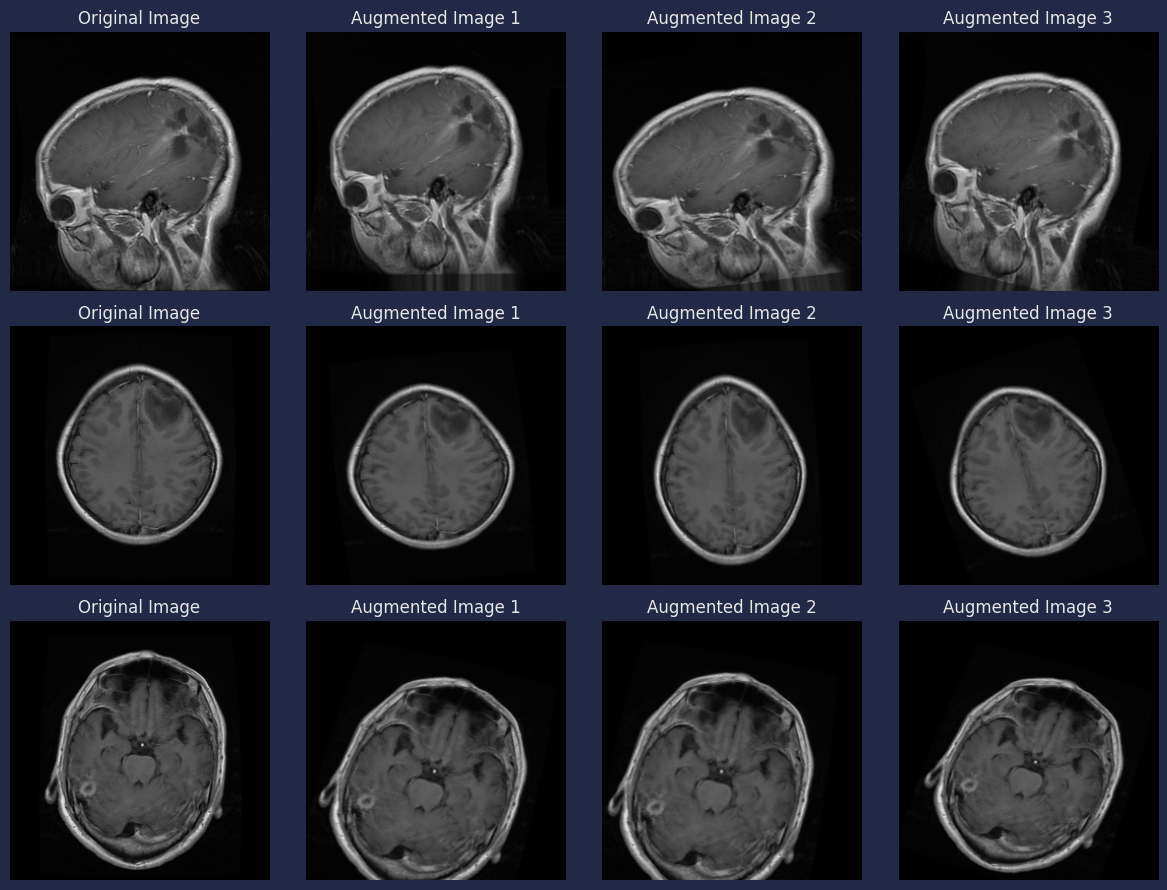

In [6]:
def visualize_augmented_images(image_generator, num_samples, num_augmented_images):
    augmented_images = []
    for sample in X_train[:num_samples]:
        
        # Create a list to store augmented versions of a sample
        augmented_samples = [sample]
        for _ in range(num_augmented_images):
            augmented_samples.append(image_generator.random_transform(sample))
        augmented_images.append(augmented_samples)

    # Plot original and augmented images
    fig, axes = plt.subplots(num_samples, num_augmented_images + 1, figsize=( 12, num_samples * 3))
    for i, sample in enumerate(augmented_images):
        for j, image in enumerate(sample):
            axes[i,j].imshow(image)
            if j == 0:
                axes[i, j].set_title('Original Image')
            else:
                axes[i,j].set_title(f'Augmented Image {j}')
            axes[i, j].axis('off')
            
    plt.tight_layout()
    plt.show()

#Visualize augmented images to see how it works
visualize_augmented_images(datagen, num_samples=3, num_augmented_images=3)

# Data Preperation

In [7]:
# Convert y_train labels to one-hot encoded format using pandas
y_train = np.array(pd.get_dummies(y_train))

In [8]:
#Split the dataset into training, testing and validation sets
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_train shape: {(X_test).shape}\n'
      f'y_train shape: {(y_test).shape}\n'
      f'y_train shape: {(X_valid).shape}\n'
      f'X_train shape: {(y_valid).shape}')

X_train shape: (2643, 256, 256, 3)
y_train shape: (2643, 4)
X_train shape: (327, 256, 256, 3)
y_train shape: (327, 4)
y_train shape: (294, 256, 256, 3)
X_train shape: (294, 4)


# Normalization

Scaling pixel values to the range [0, 1] is an important preprocessing step. It stabilizes training while improving model convergence and generalization. 

In [9]:
# Normalize pixel values of training images to the range [0,1]
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

print(f"Maximum and Minimum pixel value after normalization: {X_train.max()} - {X_train.min()}")

Maximum and Minimum pixel value after normalization: 1.0 - 0.0


# Introduction to Convolution Neural Network

Convolutional Neural Networks (CNNs) are important in Deep Learning, particularly for Computer Vision, as they allow machines to understand and analyze visual data such as images. Neural Networks excel across a wide range of datasets in Machine Learning, including images, audio, and text. CNNs are especially useful for tasks such as image classification.

<p>&nbsp;</p>

In a typical Neural Network architecture, we encounter three key layers:

1. **Input Layer**: This initial layer acts as a gateway for model input. Its neuron count corresponds to the dataset's total features, such as the number of pixels in images.

2. **Hidden Layer**: Data moves from the input layer to the hidden layers, where complex transformations take place. These layers can vary in number and neuron count, allowing the network to capture complex patterns using matrix operations, weight adjustments, biases, and activation functions.

3. **Output Layer**: The output layer receives processed data from the hidden layers and uses functions such as sigmoid or softmax to calculate probability scores for various classes.

<p>&nbsp;</p>

<span style="color:crimson;">Feedforward</span> is the process of feeding data into a neural network model and then sequentially calculating the output from each layer until the final output layer. This step involves applying transformations and activation functions to the input data as it passes through the network.


<span style="color:crimson;">Backpropagation</span>, on the other hand, is the process of changing the model's parameters (weights and biases) by computing the gradients of the loss function with respect to each parameter. These gradients are calculated using the chain rule of calculus and used to adjust the parameters in a way that reduces the loss function. This iterative process enables the model to learn from its mistakes and improves its performance over time.

<p>&nbsp;</p>

In a Convolutional Neural Network, various layers work to process input data, such as images. The Convolutional layer extracts features using filters, the Pooling layer reduces image size to improve efficiency, and the fully connected layer makes predictions. Backpropagation and gradient descent are used by the network to refine its filter parameters and improve its performance.

<p>&nbsp;</p>

*Source: [geeksforgeeks](https://www.geeksforgeeks.org/introduction-convolution-neural-network/)*

# Model with Data Augmentation

In [10]:
# Define the model
model = Sequential()

# An Input layer specifying the input shape
model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))   # the Softmax function works for multiclass classification problems 
                                            # and the Sigmoid function is a better option for binary-class problems.


model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 564,948 (2.16 MB)

 Trainable params: 564,948 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
start_time = time.time()

history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_valid, y_valid),
                    epochs=20, verbose=1)

end_time = time.time()

runtime = end_time - start_time
print("Total runtime:", runtime, "seconds")

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/42 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3672 - loss: 1.4082  

I0000 00:00:1715546281.208857      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715546281.231896      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/42 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3704 - loss: 1.3779 

W0000 00:00:1715546314.035439      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 63s 935ms/step - accuracy: 0.3734 - loss: 1.3691 - val_accuracy: 0.4116 - val_loss: 1.3119
Epoch 2/20


W0000 00:00:1715546319.594535      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 645ms/step - accuracy: 0.4019 - loss: 1.2799 - val_accuracy: 0.4490 - val_loss: 1.2419
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 630ms/step - accuracy: 0.4374 - loss: 1.1963 - val_accuracy: 0.5476 - val_loss: 1.0942
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 634ms/step - accuracy: 0.4727 - loss: 1.1536 - val_accuracy: 0.5782 - val_loss: 1.1201
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 632ms/step - accuracy: 0.4976 - loss: 1.1102 - val_accuracy: 0.6156 - val_loss: 0.9943
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 637ms/step - accuracy: 0.5242 - loss: 1.0646 - val_accuracy: 0.5408 - val_loss: 1.0113
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 630ms/step - accuracy: 0.5348 - loss: 1.0651 - val_accuracy: 0.6633 - val_loss: 0.8811
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 628ms/step - accuracy: 0.6014 - loss: 0.9773 - val_accuracy: 0.6497 - val_loss: 0.8270
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 632ms/step - accuracy: 0.6239 - loss: 0.9222 - val_accuracy: 0.619

# Confusion Matrix

I visualized the confusion matrix to gain insights, particularly in identifying areas where predictions are incorrect for both visible and unseen data. The confusion matrix is an effective tool because it provides a clear breakdown of the model's predictions across different classes and highlights areas where misclassification occurs.
<p>&nbsp;</p>

📚 In a confusion matrix, the **diagonal elements** represent **true positives**, or instances that were correctly classified for each class. **Off-diagonal elements** denote **misclassifications**, with each element (i, j) representing instances of class i predicted to be class j. As a result, the sum of values in each row (except the diagonal) indicates false negatives, whereas the sum in each column (excluding the diagonal) indicates false positives.

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


W0000 00:00:1715546941.834775      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


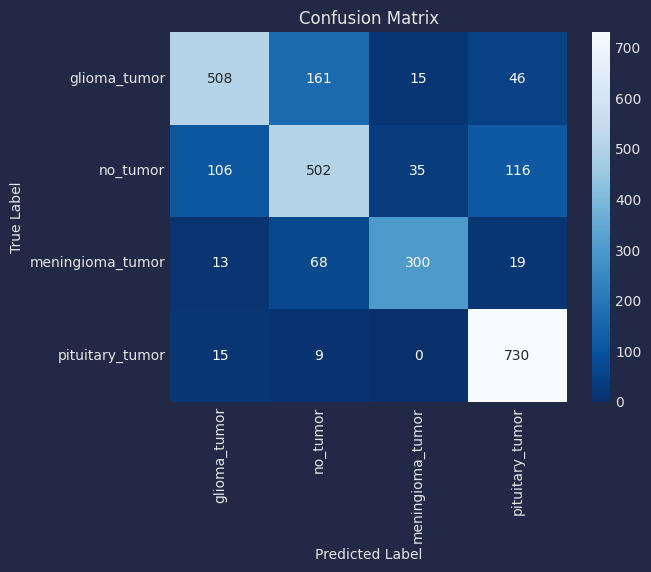

In [12]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(X_train), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


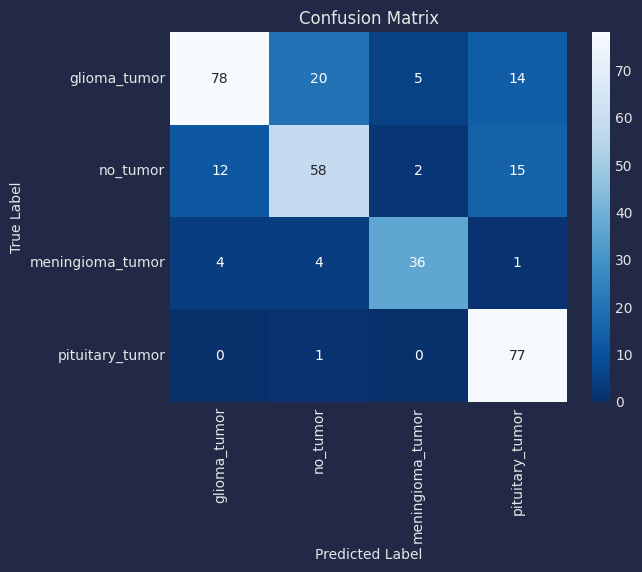

In [13]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Evaluation

**Here's an explanation of each metric in the classification report:**

<p>&nbsp;</p>

* **Precision**: Determines the accuracy of positive predictions by indicating how many of the predicted positive instances are actually positive.

* **Recall**: This metric measures the model's ability to correctly identify all relevant instances, indicating how many actual positive instances were correctly predicted.

* **F1-score**: Represents the harmonic mean of precision and recall, providing a balance between the two, which is especially useful when classes are imbalanced.

* **Support**: Indicates the number of actual occurrences of each class in the dataset, which provides context for calculating precision, recall, and F1 score.

* **Accuracy**: Indicates the overall correctness of the model's predictions by displaying the proportion of correctly predicted instances to the total number of instances.

* **Macro Avg**: Calculates the average precision, recall, and F1-score for all classes, treating each class equally regardless of class imbalance.

* **Weighted Avg**: Calculates the weighted average of precision, recall, and F1-score, with each class's score weighted by its support, providing a more accurate picture of overall model performance, particularly when classes are imbalanced.


In [14]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74       117
           1       0.70      0.67      0.68        87
           2       0.84      0.80      0.82        45
           3       0.72      0.99      0.83        78

    accuracy                           0.76       327
   macro avg       0.77      0.78      0.77       327
weighted avg       0.77      0.76      0.76       327



# Prediction

📌 Let's look at a random image and compare the actual vs. predicted label

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicted label: pituitary_tumor 
Actual label: glioma_tumor 
Confidence: 63.99%



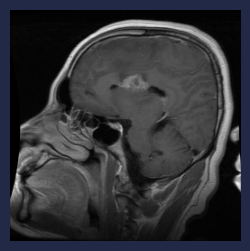

In [15]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 256, 256, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

### Performance Summary with Data Augmentation:
<p>&nbsp;</p>

* **Accuracy:** Achieves an accuracy of approximately 70% on the validation set.
* **Runtime:** Total runtime is approximately 750 seconds for 20 epochs.

>Classes 0 (glioma tumor) and 3 (pituitary tumor) have high precision, recall, and F1-scores, indicating accurate predictions.
Class 1(no_tumor) has lower recall indicating difficulty identifying instances of this class.
Class 2 (meningioma_tumor) displays moderate precision , recall, and F1-score, indicating satisfactory performance.

# Model without Data Augmentation

In [16]:
# Define the model
model = Sequential()

# An Input layer specifying the input shape
model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

    
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(4, activation='softmax'))


model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,143,364 (8.18 MB)

 Trainable params: 2,143,364 (8.18 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
start_time = time.time()

history = model.fit(X_train,y_train,validation_split=0.1, epochs =45, verbose=1, batch_size=64)

end_time = time.time()

runtime = end_time - start_time
print("Total runtime:", runtime, "seconds")

Epoch 1/45


2024-05-12 20:49:26.084396: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,128,128]{3,2,1,0}, f32[64,32,128,128]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 20:49:26.136438: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.052142824s
Trying algorithm eng0{} for conv (f32[32,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,128,128]{3,2,1,0}, f32[64,32,128,128]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 20:49:28.039065: E external/

38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 375ms/step - accuracy: 0.3535 - loss: 1.4131 - val_accuracy: 0.5321 - val_loss: 1.1474
Epoch 2/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5312 - loss: 1.1080 - val_accuracy: 0.5962 - val_loss: 0.9300
Epoch 3/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5874 - loss: 0.9412 - val_accuracy: 0.6604 - val_loss: 0.8205
Epoch 4/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6482 - loss: 0.8074 - val_accuracy: 0.6906 - val_loss: 0.7554
Epoch 5/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6995 - loss: 0.6980 - val_accuracy: 0.7019 - val_loss: 0.7536
Epoch 6/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.7245 - loss: 0.6337 - val_accuracy: 0.7547 - val_loss: 0.6070
Epoch 7/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.7714 - loss: 0.5482 - val_accuracy: 0.8075 - val_loss: 0.5060
Epoch 8/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.7842 - loss: 0.5100 - val_accuracy: 0.8302 - val_loss: 

# Confusion Matrix

83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


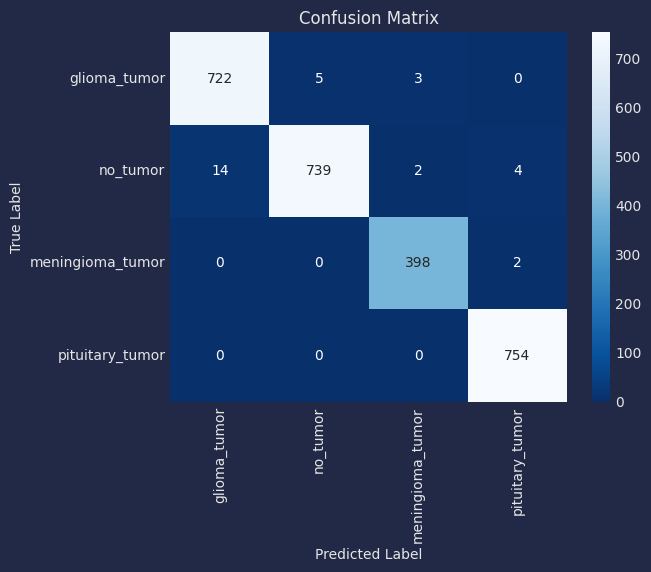

In [18]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(X_train), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


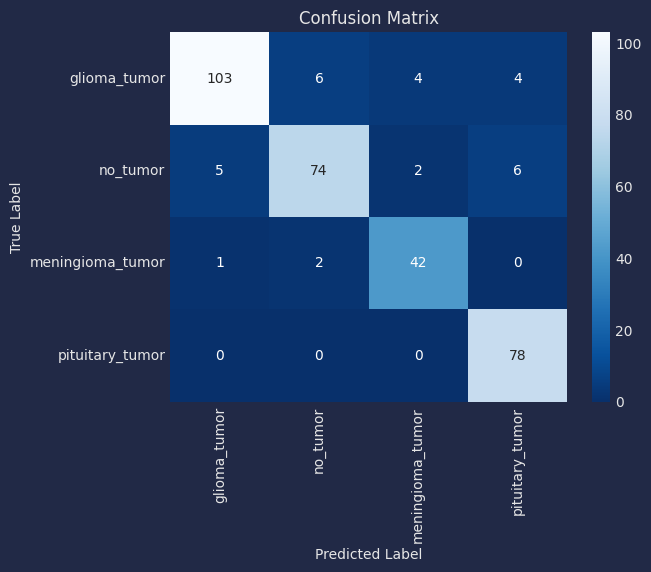

In [19]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Evaluation

In [20]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       117
           1       0.90      0.85      0.88        87
           2       0.88      0.93      0.90        45
           3       0.89      1.00      0.94        78

    accuracy                           0.91       327
   macro avg       0.90      0.92      0.91       327
weighted avg       0.91      0.91      0.91       327



### Performance Summary without Data Augmentation:
<p>&nbsp;</p>

**Accuracy:** Achieves an accuracy of approximately 90% on the validation set, indicating the proportion of correctly predicted instances in all classes.

**Runtime:** Total runtime is approximately 150 seconds for 45 epochs.

>Class 3 (pituitary_tumor) performs extremely well, with the highest precision, recall, and F1-score.
Clases 0 (glioma_tumor), 1 (no_tumor), and 2 (meningioma_tumor) perform well despite slightly lower but still impressive metrics.
Overall, both the macro average and the weighted average metrics show good model performance across all classes.



# Prediction

📌 Let's look at a random image and compare the actual vs. predicted label

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 95.57%



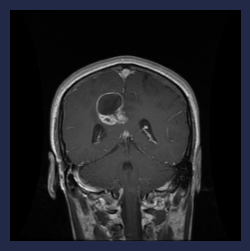

In [21]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 256, 256, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

# Conclusion

Based on the experiments conducted with two models, one with data augmentation and one without, it can be concluded:

>While both models, with and without data augmentation, achieved reasonable accuracy, our experiments showed that the model trained without augmentation produced competitive results, emphasizing the potential tradeoff between accuracy and computational complexity. However, more improvement is needed, particularly in accurately classifying the 'no_tumor' category. To address this, potential strategies involve collecting additional data, using transfer learning from pre-trained models, and exploring synthetic data generation methods. These approaches provide opportunities to address data scarcity and potentially improve model performance in tumor classification tasks.

Therefore, I've created another notebook to explore into transfer learning for enhanced performance. You can find the link to this new notebook [here](https://www.kaggle.com/code/anitarostami/brain-tumor-detection-efficientnet-resnet-xception)."


<center style="font-size:18px; color:#1357a6;">I hope you found value and insights in this notebook. If you have any suggestions or thoughts, please feel free to share them. If you enjoyed the content, consider giving it an upvote. </center>

<h1 style="font-family:verdana;"> <center>Thank you!</center> </h1>